In [1]:
from datasets import load_dataset
import numpy as np

In [2]:
dataset = load_dataset("Rtian/DebugBench")

In [3]:
import difflib

def remove_blank_lines(text):
    return "\n".join([s for s in text.splitlines() if s])

def find_changed_lines(file1_contents, file2_contents):
    diff = difflib.ndiff(file1_contents.splitlines(), file2_contents.splitlines())
    
    changed_lines = []

    current_line_number = 1
    for line in diff:        
        if line.startswith('  '):
            current_line_number += 1
            continue
        elif line.startswith('- '):  # Lines in file1 but not in file2
            changed_lines.append(current_line_number)
            current_line_number += 1        
    return changed_lines

In [4]:
import subprocess

def format_cpp_code(code):
    try:
        process = subprocess.Popen(['clang-format', '-style=file:./clang-format.txt'], 
                                   stdin=subprocess.PIPE, 
                                   stdout=subprocess.PIPE, 
                                   stderr=subprocess.PIPE)
        formatted_code, errors = process.communicate(input=code.encode())
        
        if process.returncode != 0:
            print("Error formatting code: ", errors.decode())
            return None
        
        return formatted_code.decode()
    except Exception as e:
        print(f"An exception occurred: {e}")
        return None


In [5]:
import requests as req
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()

def process_entry(entry):
    buggy_code = format_cpp_code(remove_blank_lines(entry['buggy_code']))
    num_lines = buggy_code.count('\n')
    solution = format_cpp_code(remove_blank_lines(entry['solution']))
    changed_lines = find_changed_lines(buggy_code, solution)

    data = {"prompt": buggy_code}
    success = True
    response_json = []
    try:
        resp = req.post("http://delos.eaalab.hpi.uni-potsdam.de:8010/highlight-code/", json=data)
        try:
            response_json = resp.json()
        except:
            sucess = False
            print("Json parsing failed")
            print(resp.text())
    except:
        print("Request failed")
        success = False
        
    

    predicted_lines = []
    suggestions = []
    descriptions = []
    for item in response_json:
        line_number = int(item['line_number'])
        suggestions.append(item["description"])
        descriptions.append(item["suggestion"])
        predicted_lines.append(line_number)

    return buggy_code, solution, changed_lines, predicted_lines, num_lines, success, suggestions, descriptions

df = pd.DataFrame(dataset['test'])

filtered_df = df[(df['language'] == 'cpp') & (df['category'] == 'logic error')]

filtered_df = filtered_df



print("Total number of cpp logic error examples: ", len(filtered_df))

results = filtered_df.progress_apply(process_entry, axis=1)



Total number of cpp logic error examples:  200


  0%|          | 0/200 [00:00<?, ?it/s]

Json parsing failed
Request failed
Json parsing failed
Request failed
Json parsing failed
Request failed
Json parsing failed
Request failed
Json parsing failed
Request failed
Json parsing failed
Request failed
Json parsing failed
Request failed
Json parsing failed
Request failed
Json parsing failed
Request failed
Json parsing failed
Request failed
Json parsing failed
Request failed
Json parsing failed
Request failed


In [6]:
df = pd.DataFrame([[a,b,c,d,e,f,g,h] for a,b,c,d,e,f,g,h in results.values], columns=['buggy_code', 'solution', 'changed_lines', 'predicted_lines', 'num_lines', 'success', 'suggestions', 'descriptions'])

In [7]:
success_df = df[df["success"]]

In [8]:
print(len(success_df))

188


In [9]:
def create_labels(row):
    labels = pd.Series([0] * row['num_lines'])
    for line in row['changed_lines']:
        labels[line - 1] = 1
    assert len(labels) == row['num_lines']
    return labels.tolist()

def create_predictions(row):
    predictions = pd.Series([0] * row['num_lines'])
    for line in row['predicted_lines']:
        if line == -1:
            continue
        if line >= row['num_lines']:
            print(f"Error {line} exceeds {row['num_lines']}")
        predictions[line - 1] = 1
    assert len(predictions) == row['num_lines']
    return predictions.tolist()

success_df['labels'] = success_df.apply(create_labels, axis=1)
success_df['predictions'] = success_df.apply(create_predictions, axis=1)

labels = np.array([b for a in success_df['labels'].values for b in a])
predictions = np.array([b for a in success_df['predictions'].values for b in a])
assert len(labels) == len(predictions)

Error 33 exceeds 33


/tmp/ipykernel_16009/1312671670.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  success_df['labels'] = success_df.apply(create_labels, axis=1)
/tmp/ipykernel_16009/1312671670.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  success_df['predictions'] = success_df.apply(create_predictions, axis=1)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.6666666666666666
Area 0.6331388206388207


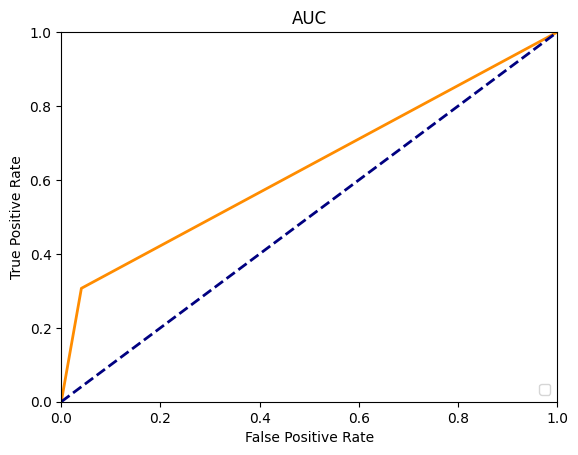

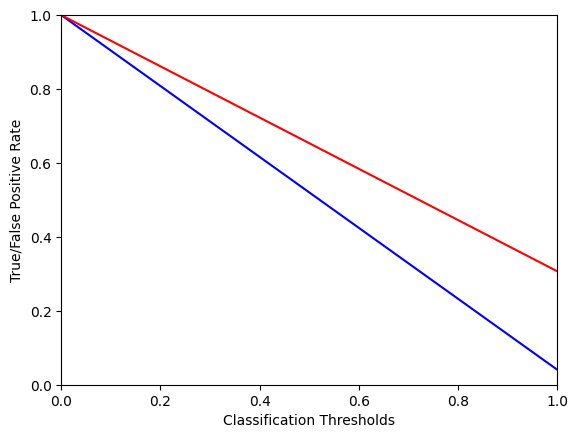

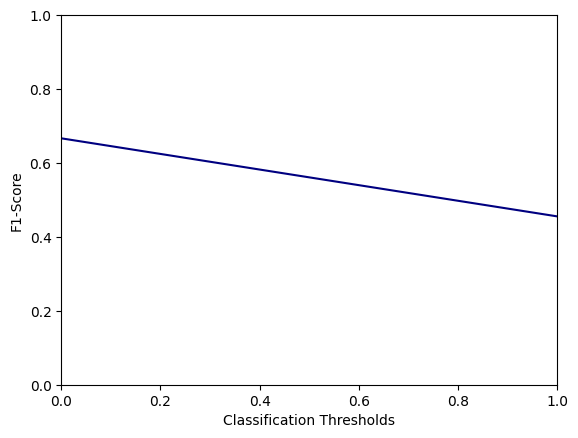

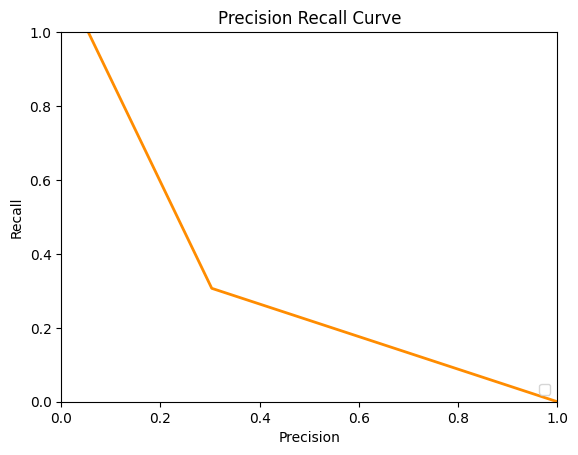

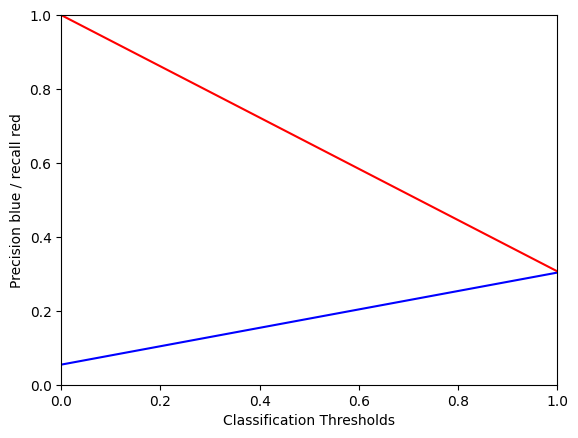

In [10]:
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc, precision_recall_curve

num_positives = labels.sum()

fpr, tpr, thresholds = roc_curve(labels, predictions)
precision, recall, thresholds2 = precision_recall_curve(labels, predictions)
fn = [(num_positives) - tp * num_positives for tp in tpr]
f1 = [(2*tpr[i]*num_positives)/(2*tpr[i]*num_positives + fpr[i]*num_positives + fn[i]) for i in range(len(fpr))]
print(max(f1))

roc_auc = auc(fpr, tpr)
print("Area", roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC')
plt.legend(loc='lower right')

plt.figure()
plt.plot(thresholds, fpr, color='blue')
plt.plot(thresholds, tpr, color='red')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Classification Thresholds')
plt.ylabel('True/False Positive Rate')

plt.figure()
plt.plot(thresholds, f1, color='navy')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Classification Thresholds')
plt.ylabel('F1-Score')

plt.figure()
plt.plot(precision, recall, color='darkorange', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision Recall Curve')
plt.legend(loc='lower right')

length = min(len(precision), len(recall))
plt.figure()
plt.plot(thresholds2, precision[:length-1], color='blue')
plt.plot(thresholds2, recall[:length-1], color='red')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Classification Thresholds')
plt.ylabel('Precision blue / recall red')

plt.show()